# Testing DEMV on _Wine Quality_ Dataset

- Label: `quality`
- Positive label: `quality=6`
- Unprivileged group: `type=1 (white)`

Source: [https://archive.ics.uci.edu/ml/datasets/wine+quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)

In [19]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearnex import patch_sklearn

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from demv import DEMV
from utils import *

import warnings
warnings.filterwarnings('ignore')

#patch_sklearn()
sns.set_style('whitegrid')

In [20]:
def load_data():
  red = pd.read_csv('data/winequality-red.csv', sep=';')
  red['type'] = 0
  white = pd.read_csv('data/winequality-white.csv', sep=';')
  white['type'] = 1
  data = red.append(white)
  data.drop(data[(data['quality']==3)|(data['quality']==9)].index, inplace=True)
  data.loc[data['alcohol'] <= 10, 'alcohol'] = 0
  data.loc[(data['alcohol'] > 10) & (data['alcohol'] != 0), 'alcohol'] = 1
  return data

In [21]:
data = load_data()

In [22]:
label = 'quality'
sensitive_variables = ['alcohol', 'type']
protected_group = {'alcohol': 0, 'type': 1}
positive_label = 6

In [23]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression(n_jobs=-1))
])

## Biased dataset

In [24]:
model, bias_metrics = cross_val(pipeline, data, label, protected_group, sensitive_variables,positive_label=positive_label)

In [25]:
print_metrics(bias_metrics)

Statistical parity:  -0.315  +-  0.032
Disparate impact:  0.544  +-  0.043
Zero one loss:  0.154  +-  0.028
F1 score:  0.514  +-  0.021
Accuracy score:  0.543  +-  0.021


## DEMV dataset

In [26]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [27]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_variables, positive_label=positive_label, debiaser=demv)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
print_metrics(demv_metrics)

Statistical parity:  -0.106  +-  0.049
Disparate impact:  0.856  +-  0.06
Zero one loss:  0.121  +-  0.052
F1 score:  0.451  +-  0.017
Accuracy score:  0.502  +-  0.015


## Exponentiated Gradient

In [29]:
constr = BoundedGroupLoss(ZeroOneLoss(), upper_bound=0.1)
model = ExponentiatedGradient(
    pipeline, constr, sample_weight_name="classifier__sample_weight")
exp_data = data.copy()

In [30]:
model, exp_metrics = cross_val(model, exp_data, label, protected_group, sensitive_variables, positive_label=positive_label, exp=True)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [31]:
print_metrics(exp_metrics)

Statistical parity:  -0.325  +-  0.038
Disparate impact:  0.534  +-  0.05
Zero one loss:  0.168  +-  0.023
F1 score:  0.512  +-  0.015
Accuracy score:  0.542  +-  0.015


## DEMV Evaluation

In [32]:
demv.get_iters()

384

In [33]:
metrics = eval_demv(76, demv.get_iters(), data.copy(), pipeline, label,
                    protected_group, sensitive_variables, positive_label=positive_label)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [34]:
df = prepareplots(metrics,'wineSinglevar')

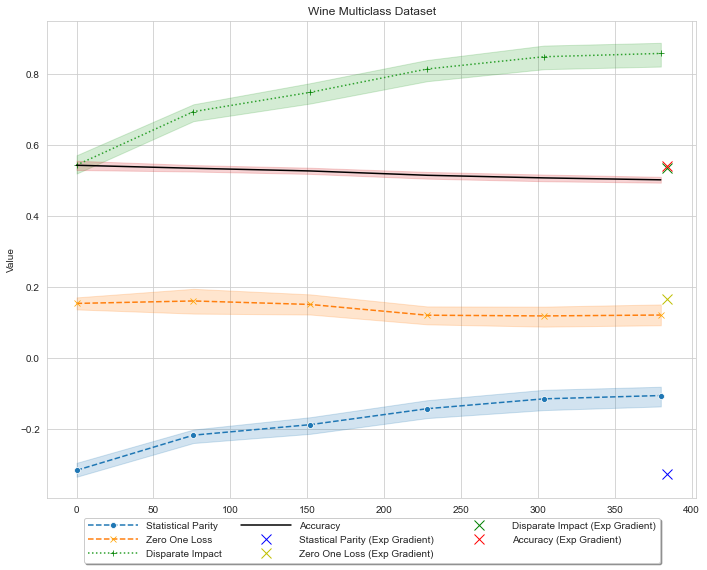

In [35]:
points = preparepoints(exp_metrics, demv.get_iters())

plot_metrics_curves(df, points, 'Wine Multiclass Dataset')


In [36]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 6438
Unprivileged group size: 2074
Percentage of unprivileged group: 32.21497359428394
Number of iterations: 384
